In [29]:
# !pip install -r /workspaces/codespaces-jupyter/requirements.txt

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import os

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('timm version', timm.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)


System Version: 3.12.1 (main, Oct 16 2024, 18:21:33) [GCC 9.4.0]
PyTorch version 2.3.0+cu121
Torchvision version 0.18.0+cu121
timm version 1.0.12
Numpy version 2.1.2
Pandas version 2.2.2


3


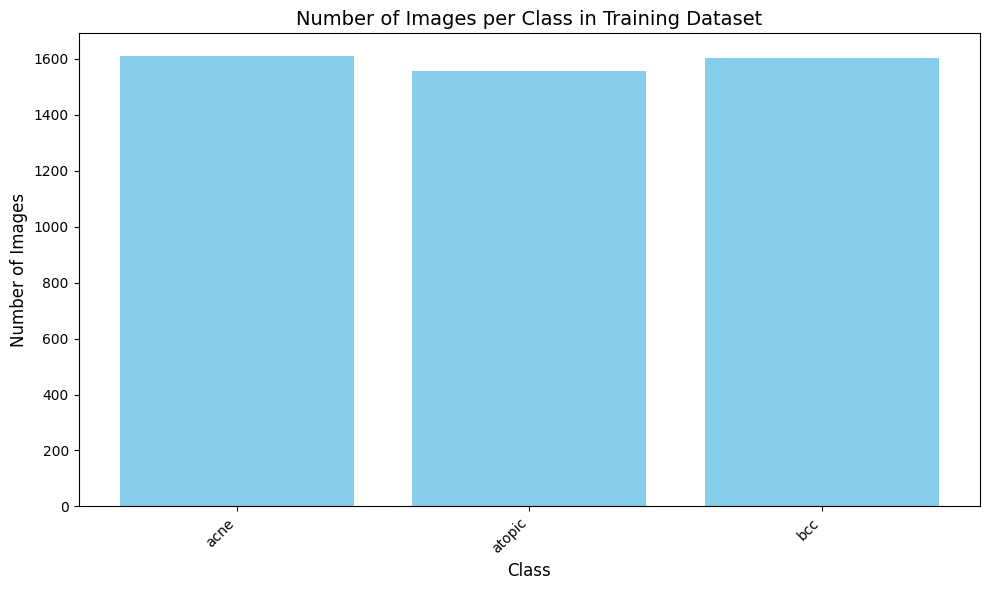

In [31]:
# Path to the train folder
train_path = '/workspaces/codespaces-jupyter/data/roboflow/train'

# Get class names (subfolder names) and count images
class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        class_counts[class_name] = len([
            f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))
        ])

# Sort classes alphabetically (optional)
class_counts = dict(sorted(class_counts.items()))
print(len(class_counts))
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images per Class in Training Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.tight_layout()
plt.show()

In [32]:
class SkinDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    @property
    def classes(self):
        return self.data.classes

In [33]:
dataset = SkinDataset(
    data_dir='/workspaces/codespaces-jupyter/data/roboflow/train'
)

In [34]:
len(dataset)

4773

0


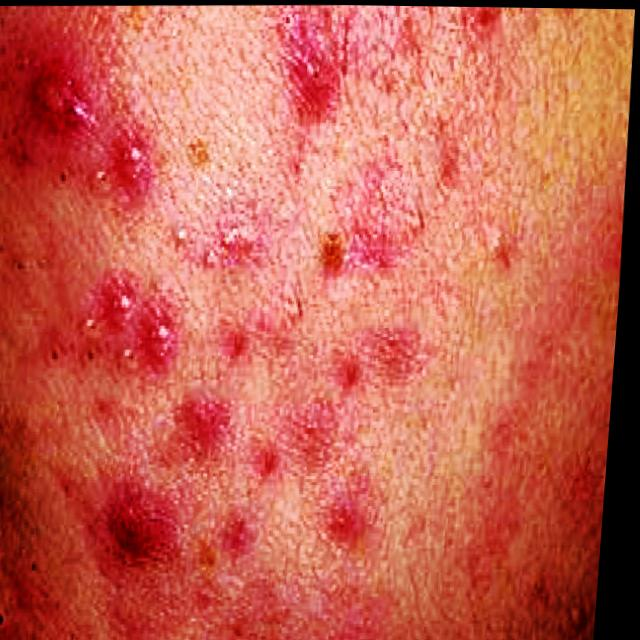

In [35]:
image, label = dataset[1500]
print(label)
image

In [36]:
data_dir = '/workspaces/codespaces-jupyter/data/roboflow/train'
target_to_class = {v : k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'acne', 1: 'atopic', 2: 'bcc'}


In [37]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.Resize([640,640]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])
data_dir = '/workspaces/codespaces-jupyter/data/roboflow/train'
dataset = SkinDataset(data_dir, train_transform)

In [38]:
image, label = dataset[100]
image.shape

torch.Size([3, 640, 640])

In [39]:
# iterate over dataset
for image, label in dataset:
    break

DataLoaders

In [40]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
for images, labels in dataloader:
    break

images.shape, labels.shape

(torch.Size([32, 3, 640, 640]), torch.Size([32]))

In [42]:
labels

tensor([1, 0, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 2,
        2, 1, 1, 0, 1, 0, 0, 2])

### Pytorch Model

In [43]:
class SkinDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(SkinDiseaseClassifier, self).__init__()
        # Load base model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        enet_out_size = self.base_model.num_features

        # Define a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self , x):
        # Extract features from the base model
        x = self.base_model(x)
        # Pass through the classifier
        output = self.classifier(x)
        return output

In [44]:
model = SkinDiseaseClassifier(num_classes=3)

Training Loop

In [45]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
transform = transforms.Compose([
    transforms.Resize([640, 128]),
    transforms.ToTensor()
])

train_folder = '/workspaces/codespaces-jupyter/data/roboflow/train'
test_folder = '/workspaces/codespaces-jupyter/data/roboflow/test'
valid_foler = '/workspaces/codespaces-jupyter/data/roboflow/valid'

train_dataset = SkinDataset(train_folder, transform=train_transform)
test_dataset = SkinDataset(test_folder, transform=transform)
valid_dataset = SkinDataset(valid_foler, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

: 

In [ ]:
num_epochs = 20
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SkinDiseaseClassifier(num_classes=3)
model.to(device)

# Early stopping parameters
patience = 3  # Stop if no improvement after 'patience' epochs
best_val_loss = float("inf")
epochs_no_improve = 0

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Accumulate predictions and true labels for the entire training loop
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Step the scheduler
    scheduler.step()

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    print(f"Current learning rate: {scheduler.get_last_lr()[0]}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter if improvement is seen
        print("Validation loss improved. Saving the model...")
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break
    
    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    print(f"Current learning rate: {scheduler.get_last_lr()[0]}")

Training loop:   0%|          | 0/150 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     Class 0       0.86      0.66      0.74       288
     Class 1       0.46      0.88      0.60       280
     Class 2       0.77      0.24      0.37       272

    accuracy                           0.60       840
   macro avg       0.70      0.59      0.57       840
weighted avg       0.70      0.60      0.58       840



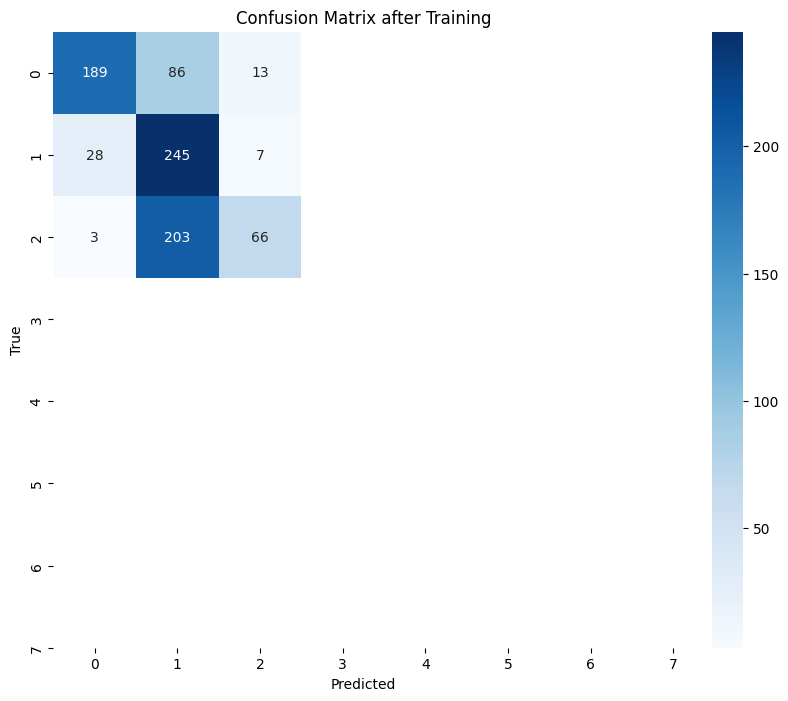

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# After all epochs, print the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print classification report (Precision, Recall, F1-score, Accuracy)
report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(len(np.unique(all_labels)))])
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.title(f"Confusion Matrix after Training")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

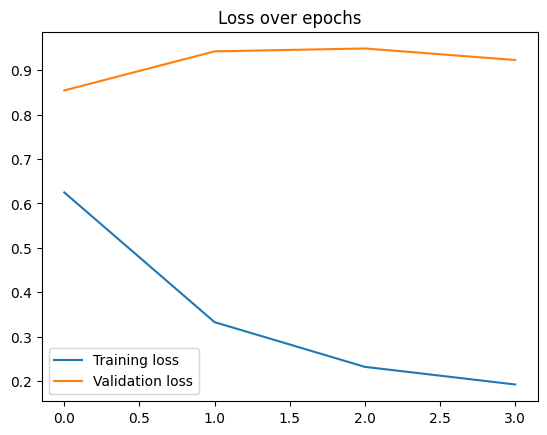

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

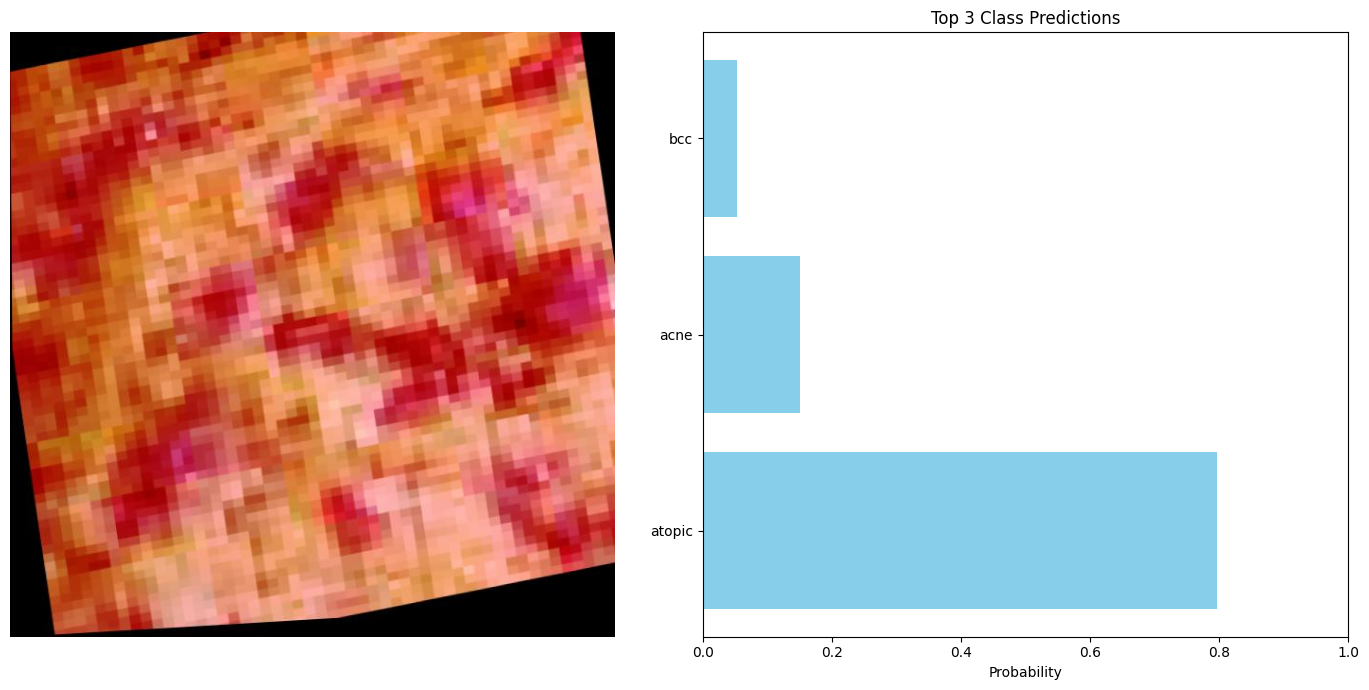

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    # Get top 3 predictions
    top3_indices = np.argsort(probabilities)[-3:][::-1]  # Indices of top 3 probabilities
    top3_probs = probabilities[top3_indices]
    top3_classes = [class_names[i] for i in top3_indices]

    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(top3_classes, top3_probs, color='skyblue')
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Top 3 Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/workspaces/codespaces-jupyter/data/roboflow/train/acne/15O_jpg.rf.c93b9bd1996823d0551b53b836495567.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)